In [32]:
!python -m pip install opencv-python-headless

In [28]:
import cv2
import numpy as np

print("OpenCV:", cv2.__version__)
print("NumPy:", np.__version__)

OpenCV: 4.12.0
NumPy: 2.0.2


## Import Library

In [30]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mount Data

In [4]:
#1. mount google
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Ekstraksi Fitur

In [5]:

def ekstrak_fitur_gambar(img_input):
    try:
        # Cek tipe input
        if isinstance(img_input, str):
            img = cv2.imread(img_input)
            if img is None:
                print(f"Error: Gambar tidak dapat dibaca dari path: {img_input}")
                return None
        elif isinstance(img_input, np.ndarray):
            img = img_input
        else:
            print("Error: Input harus berupa path string atau numpy array gambar.") #takut lupa
            return None

        # Resize agar konsisten
        if img.shape[0] != 128 or img.shape[1] != 128:
            img = cv2.resize(img, (128, 128))

        # Konversi ke grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # ===== GLCM (Tekstur) =====
        glcm = graycomatrix(gray, distances=[1], angles=[0], symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        # ===== Histogram Warna =====
        hist_b = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
        hist_g = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
        hist_r = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()

        # Normalisasi histogram
        hist_b = hist_b / hist_b.sum() if hist_b.sum() != 0 else hist_b
        hist_g = hist_g / hist_g.sum() if hist_g.sum() != 0 else hist_g
        hist_r = hist_r / hist_r.sum() if hist_r.sum() != 0 else hist_r
        # Debugging: Print jumlah dari histograms
       # print(f"Debug: jumlah histograms: B={hist_b.sum()}, G={hist_g.sum()}, R={hist_r.sum()}")

        fitur_hist = np.hstack([hist_b, hist_g, hist_r])

        # Gabung semua fitur
        fitur = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, fitur_hist])
        return fitur
    except Exception as e:
        print(f"Error ekstrak fitur: {e}")
        return None

## Load Data

In [7]:
# ====== 1) Path Dataset ======
csv_path = "/content/drive/MyDrive/A Skripsi/CSV/databaseJBC.csv"
image_dir = "/content/drive/MyDrive/A Skripsi/Extraksi"

df = pd.read_csv(csv_path)

X = []
y = []

for idx, row in df.iterrows():
    if pd.isna(row["FotoCS"]):
        print(f"Nama File tidak valid pada indeks {idx}.")
        continue

    img_path = os.path.join(image_dir, row["FotoCS"])
    if os.path.exists(img_path):
        fitur = ekstrak_fitur_gambar(img_path)  # lewat img_path daripada img
        if fitur is not None:
            X.append(fitur)
            y.append(row["Tekstur Kulit"])
    else:
        print(f"File tidak ditemukan: {img_path}") # Print the constructed path to help debugging
X = np.array(X)
y = np.array(y)
print(f"Jumlah data asli: {len(X)}")

File tidak ditemukan: /content/drive/MyDrive/A Skripsi/Extraksi/1755069446507.jpg
Jumlah data asli: 312


In [8]:
df = pd.read_csv(csv_path)
print(df.head())

              FotoCS  Ukuran (KB) Tipe File  \
0  1755069443238.jpg    85.176758      .jpg   
1  1755069443257.jpg   103.005859      .jpg   
2  1755069443274.jpg   105.710938      .jpg   
3  1755069443293.jpg    90.321289      .jpg   
4  1755069443311.jpg    92.083008      .jpg   

                                      pixel_features  kadar minyak  kadar air  \
0  [49, 48, 46, 48, 46, 45, 48, 46, 46, 43, 43, 4...          0.60       0.35   
1  [255, 255, 254, 253, 253, 252, 250, 250, 245, ...          0.30       0.65   
2  [193, 162, 123, 194, 162, 123, 196, 164, 125, ...          0.30       0.65   
3  [197, 200, 204, 201, 202, 206, 203, 204, 208, ...          0.55       0.40   
4  [248, 248, 245, 255, 255, 255, 255, 255, 255, ...          0.55       0.40   

  ukuran pori Tekstur Kulit  
0      sedang        normal  
1       kecil           dry  
2       kecil           dry  
3      sedang        normal  
4      sedang        normal  


## Split Data & Latih Model Sebelum Augmentasi

Akurasi Sebelum Augmentasi: 0.36507936507936506

=== Classification Report (Sebelum Augmentasi) ===
              precision    recall  f1-score   support

         dry       0.28      0.31      0.29        16
      normal       0.00      0.00      0.00        20
        oily       0.42      0.67      0.51        27

    accuracy                           0.37        63
   macro avg       0.23      0.33      0.27        63
weighted avg       0.25      0.37      0.30        63



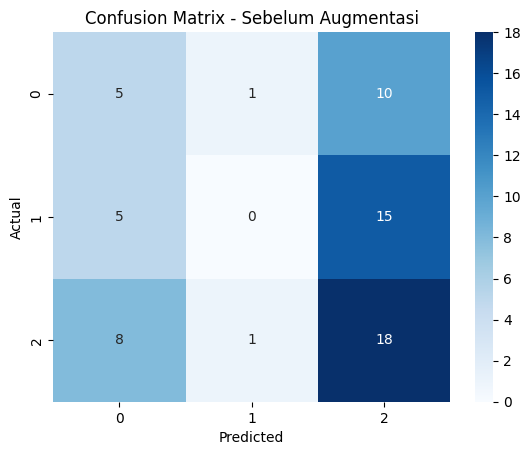

In [9]:
if len(X) == 0:
    print("Error: tidak ada data, cek lagi.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Dibagi datanya

    model_before = RandomForestClassifier(n_estimators=100, random_state=42)
    model_before.fit(X_train, y_train)
    y_pred_before = model_before.predict(X_test)
    acc_before = accuracy_score(y_test, y_pred_before)

    print("Akurasi Sebelum Augmentasi:", acc_before)

    print("\n=== Classification Report (Sebelum Augmentasi) ===")
    print(classification_report(y_test, y_pred_before))

    cm_before = confusion_matrix(y_test, y_pred_before)
    sns.heatmap(cm_before, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Sebelum Augmentasi")
    plt.xlabel("Predicted")
    plt.ylabel("Actual") # missing ylabel
    plt.show()


## Data Augmentasi
karena akurasi sangat rendah, jadi kita augmentasi dengan  transformasi seperti rotasi sebesar 15°, pergeseran horizontal dan vertikal sebesar 10%, zoom 10%, dan pembalikan horizontal.

In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

X_aug = []
y_aug = []

for idx, row in df.iterrows():
    img_path = os.path.join(image_dir, row["FotoCS"])
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Peringatan: Tidak dapat membaca file gambar pada {img_path}")
            continue
        img = cv2.resize(img, (128, 128))
        img = np.expand_dims(img, 0)  # Tambah dimensi batch

        # Generate beberapa gambar augmentasi
        aug_iter = datagen.flow(img, batch_size=1)
        for _ in range(2):  # jumlah augmentasi per gambar
            aug_img = next(aug_iter)[0].astype(np.uint8)
            fitur = ekstrak_fitur_gambar(aug_img)
            if fitur is not None:
                X_aug.append(fitur)
                y_aug.append(row["Tekstur Kulit"])
        else:
             # Original image features
             fitur = ekstrak_fitur_gambar(img[0]) # Extract features dari original image
             if fitur is not None:
                X_aug.append(fitur)
                y_aug.append(row["Tekstur Kulit"])




# Gabungkan data asli + augmentasi
X_total = np.vstack([X, X_aug])
y_total = np.hstack([y, y_aug])

print(f"Jumlah data setelah augmentasi: {len(X_total)}")


Jumlah data setelah augmentasi: 1248


##Latih Model Sesudah Augmentasi

Akurasi Setelah Augmentasi: 0.88

=== Classification Report (Setelah Augmentasi) ===
              precision    recall  f1-score   support

         dry       0.93      0.82      0.87        87
      normal       0.84      0.90      0.87        62
        oily       0.87      0.92      0.89       101

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250



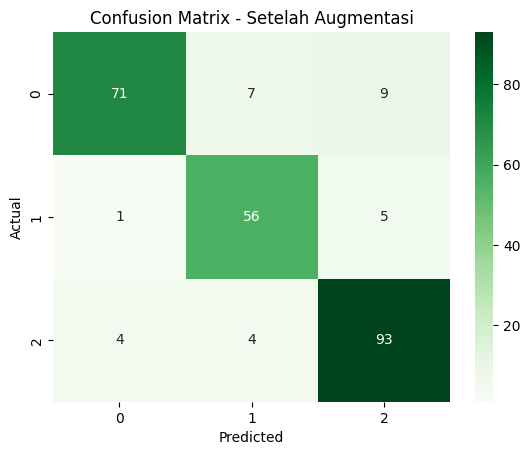

In [11]:
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_total, y_total, test_size=0.2, random_state=42
)

model_after = RandomForestClassifier(n_estimators=100, random_state=42)
model_after.fit(X_train_aug, y_train_aug)
y_pred_after = model_after.predict(X_test_aug)
acc_after = accuracy_score(y_test_aug, y_pred_after)

print("Akurasi Setelah Augmentasi:", acc_after)

print("\n=== Classification Report (Setelah Augmentasi) ===")
print(classification_report(y_test_aug, y_pred_after))

cm_after = confusion_matrix(y_test_aug, y_pred_after)
sns.heatmap(cm_after, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Setelah Augmentasi")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Visualisasi Perbandingan Akurasi

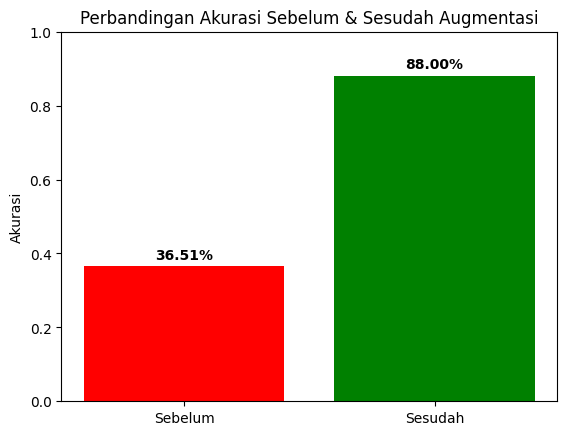

In [12]:
acc_values = [acc_before, acc_after]
labels = ["Sebelum", "Sesudah"]
colors = ["red", "green"]

plt.bar(labels, acc_values, color=colors)
plt.ylabel("Akurasi")
plt.title("Perbandingan Akurasi Sebelum & Sesudah Augmentasi")
plt.ylim(0, 1)

# Angka persentasenya
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontweight='bold')

plt.show()


## Simpan Akurasi

In [13]:
accuracy_results = {
    "Tanpa Augmentasi": acc_before,
    "Dengan Augmentasi": acc_after
}

print("\nSaved Accuracy Results:")
print(accuracy_results)


Saved Accuracy Results:
{'Tanpa Augmentasi': 0.36507936507936506, 'Dengan Augmentasi': 0.88}


## Uji coba dengan citra baru

In [14]:
# UJi COBA 1
from google.colab import files
import os
import cv2
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Pastikan LabelEncoder sudah diinisialisasi dan di-fit dengan semua label yang ada
# Lakukan fitting encoder dengan semua label unik dari data pelatihan
le = LabelEncoder()
le.fit(y_total)

print(f"UPLOAD FOTO ANDA DISINI")
print(f"UNTUK MENENTUKAN JENIS KULIT: {np.unique(y_total)}")

uploaded = files.upload()

for fn in uploaded.keys():
    print(f'\nUser mengunggah file "{fn}" ({len(uploaded[fn])} bytes)')

    # Simpan file yang diunggah ke lokasi sementara
    temp_new_image_path = f"/tmp/{fn}"
    with open(temp_new_image_path, 'wb') as f:
        f.write(uploaded[fn])

    # Ekstrak fitur dari foto baru
    # Gunakan fungsi yang menerima path sebagai input
    new_image_features = ekstrak_fitur_gambar(temp_new_image_path)

    # Hapus file sementara
    os.remove(temp_new_image_path)

    if new_image_features is not None:
        # Ubah bentuk fitur agar sesuai dengan input model (1 sampel, banyak fitur)
        new_image_features = new_image_features.reshape(1, -1)

        # Prediksi label menggunakan model_after (model setelah augmentasi)
        # RandomForestClassifier.predict() langsung mengembalikan label kelas yang diprediksi (string)
        predicted_label = model_after.predict(new_image_features)[0]  # Ambil satu label prediksi

        # Prediksi probabilitas
        prediction_probabilities = model_after.predict_proba(new_image_features)[0]

        print(f"Hasil prediksi jenis kulit: **{predicted_label}**")  # Gunakan label prediksi langsung
        print("Probabilitas:")
        # Urutkan probabilitas berdasarkan nama kelas agar output konsisten
        sorted_classes = sorted(zip(le.classes_, prediction_probabilities), key=lambda x: x[0])
        for class_name, prob in sorted_classes:
             print(f"- {class_name}: {prob:.2f}")

    else:
        print(f"Gagal mengekstrak fitur dari foto '{fn}'. Pastikan file adalah gambar yang valid.")


UPLOAD FOTO ANDA DISINI
UNTUK MENENTUKAN JENIS KULIT: ['dry' 'normal' 'oily']


Saving 6087071821238225109.jpg to 6087071821238225109.jpg

User mengunggah file "6087071821238225109.jpg" (73639 bytes)
Hasil prediksi jenis kulit: **oily**
Probabilitas:
- dry: 0.36
- normal: 0.17
- oily: 0.47


In [15]:
# UJi COBA 2
from google.colab import files
import os
import cv2
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Pastikan LabelEncoder sudah diinisialisasi dan di-fit dengan semua label yang ada
# Lakukan fitting encoder dengan semua label unik dari data pelatihan
le = LabelEncoder()
le.fit(y_total)

print(f"UPLOAD FOTO ANDA DISINI")
print(f"UNTUK MENENTUKAN JENIS KULIT: {np.unique(y_total)}")

uploaded = files.upload()

for fn in uploaded.keys():
    print(f'\nUser mengunggah file "{fn}" ({len(uploaded[fn])} bytes)')

    # Simpan file yang diunggah ke lokasi sementara
    temp_new_image_path = f"/tmp/{fn}"
    with open(temp_new_image_path, 'wb') as f:
        f.write(uploaded[fn])

    # Ekstrak fitur dari foto baru
    # Gunakan fungsi yang menerima path sebagai input
    new_image_features = ekstrak_fitur_gambar(temp_new_image_path)

    # Hapus file sementara
    os.remove(temp_new_image_path)

    if new_image_features is not None:
        # Ubah bentuk fitur agar sesuai dengan input model (1 sampel, banyak fitur)
        new_image_features = new_image_features.reshape(1, -1)

        # Prediksi label menggunakan model_after (model setelah augmentasi)
        # RandomForestClassifier.predict() langsung mengembalikan label kelas yang diprediksi (string)
        predicted_label = model_after.predict(new_image_features)[0]  # Ambil satu label prediksi

        # Prediksi probabilitas
        prediction_probabilities = model_after.predict_proba(new_image_features)[0]

        print(f"Hasil prediksi jenis kulit: **{predicted_label}**")  # Gunakan label prediksi langsung
        print("Probabilitas:")
        # Urutkan probabilitas berdasarkan nama kelas agar output konsisten
        sorted_classes = sorted(zip(le.classes_, prediction_probabilities), key=lambda x: x[0])
        for class_name, prob in sorted_classes:
             print(f"- {class_name}: {prob:.2f}")

    else:
        print(f"Gagal mengekstrak fitur dari foto '{fn}'. Pastikan file adalah gambar yang valid.")


UPLOAD FOTO ANDA DISINI
UNTUK MENENTUKAN JENIS KULIT: ['dry' 'normal' 'oily']


Saving 6113854210798896882.jpg to 6113854210798896882.jpg

User mengunggah file "6113854210798896882.jpg" (116134 bytes)
Hasil prediksi jenis kulit: **oily**
Probabilitas:
- dry: 0.35
- normal: 0.20
- oily: 0.46


In [16]:
# UJi COBA 3
from google.colab import files
import os
import cv2
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Pastikan LabelEncoder sudah diinisialisasi dan di-fit dengan semua label yang ada
# Lakukan fitting encoder dengan semua label unik dari data pelatihan
le = LabelEncoder()
le.fit(y_total)

print(f"UPLOAD FOTO ANDA DISINI")
print(f"UNTUK MENENTUKAN JENIS KULIT: {np.unique(y_total)}")

uploaded = files.upload()

for fn in uploaded.keys():
    print(f'\nUser mengunggah file "{fn}" ({len(uploaded[fn])} bytes)')

    # Simpan file yang diunggah ke lokasi sementara
    temp_new_image_path = f"/tmp/{fn}"
    with open(temp_new_image_path, 'wb') as f:
        f.write(uploaded[fn])

    # Ekstrak fitur dari foto baru
    # Gunakan fungsi yang menerima path sebagai input
    new_image_features = ekstrak_fitur_gambar(temp_new_image_path)

    # Hapus file sementara
    os.remove(temp_new_image_path)

    if new_image_features is not None:
        # Ubah bentuk fitur agar sesuai dengan input model (1 sampel, banyak fitur)
        new_image_features = new_image_features.reshape(1, -1)

        # Prediksi label menggunakan model_after (model setelah augmentasi)
        # RandomForestClassifier.predict() langsung mengembalikan label kelas yang diprediksi (string)
        predicted_label = model_after.predict(new_image_features)[0]  # Ambil satu label prediksi

        # Prediksi probabilitas
        prediction_probabilities = model_after.predict_proba(new_image_features)[0]

        print(f"Hasil prediksi jenis kulit: **{predicted_label}**")  # Gunakan label prediksi langsung
        print("Probabilitas:")
        # Urutkan probabilitas berdasarkan nama kelas agar output konsisten
        sorted_classes = sorted(zip(le.classes_, prediction_probabilities), key=lambda x: x[0])
        for class_name, prob in sorted_classes:
             print(f"- {class_name}: {prob:.2f}")

    else:
        print(f"Gagal mengekstrak fitur dari foto '{fn}'. Pastikan file adalah gambar yang valid.")


UPLOAD FOTO ANDA DISINI
UNTUK MENENTUKAN JENIS KULIT: ['dry' 'normal' 'oily']


Saving WhatsApp Image 2025-08-12 at 16.40.25_c047e2d4.jpg to WhatsApp Image 2025-08-12 at 16.40.25_c047e2d4.jpg

User mengunggah file "WhatsApp Image 2025-08-12 at 16.40.25_c047e2d4.jpg" (87153 bytes)
Hasil prediksi jenis kulit: **oily**
Probabilitas:
- dry: 0.30
- normal: 0.15
- oily: 0.55


#Mengecek data setelah augmentasi

In [17]:
print("Sample of augmented features (X_total):")
print(X_total[:5])
print("\nSample of augmented labels (y_total):")
print(y_total[:5])

Sample of augmented features (X_total):
[[3.20937623e+02 1.00546260e+01 2.05341243e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.16177227e+02 1.20521038e+01 1.44514722e-01 ... 5.92041016e-03
  8.78906250e-03 2.49633789e-02]
 [2.85173351e+02 9.58513780e+00 1.87699578e-01 ... 1.83105469e-03
  2.13623047e-03 2.68554688e-03]
 [3.10841166e+02 8.27214567e+00 3.13089004e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.04638718e+02 6.53426427e+00 4.05998214e-01 ... 5.67626953e-03
  1.33666992e-02 2.70874023e-01]]

Sample of augmented labels (y_total):
['normal' 'dry' 'dry' 'normal' 'normal']


In [21]:
#membuat dataframe setelah augmentasi
augmented_df = pd.DataFrame(X_total)
augmented_df['Tekstur Kulit'] = y_total

# Define the path to save the augmented data
augmented_csv_path = "/content/drive/MyDrive/A Skripsi/CSV/augmented_databaseJBC.csv"

# Simpan DataFrame ke CSV dengan backslash delimiter
augmented_df.to_csv(augmented_csv_path, sep='\\', index=False)

print(f"Augmented data saved to: {augmented_csv_path}")

Augmented data saved to: /content/drive/MyDrive/A Skripsi/CSV/augmented_databaseJBC.csv


In [26]:
from google.colab import files

augmented_csv_path = "/content/drive/MyDrive/A Skripsi/CSV/augmented_databaseJBC.csv"
files.download(augmented_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>